# Next Character Prediction
_Student 902011, Moleri Andrea, a.moleri@campus.unimib.it_

The task is next character prediction in a text. Starting from the provided skeleton of the code:

- properly divide the sequences into training, validation and test. Eventually use an external text for the test to assess the generalization ability
- evaluate the trained model in terms of prediction accuracy
- tune the chunk length to obtain the best performance
- modify the network architecture to obtain the best performance

In aggiunta:

Comunque vuole sia il notebook che la stampa in PDF del notebook

### Inspecting the Data

The assignment we are about to conduct is based on Dante Alighieri's "The Divine Comedy", which will serve as the dataset for the analysis in question. First, the text is downloaded from my personal GitHub repository, where it is stored in RAW format, in order to avoid compatibility problems for users who access the notebook from Google Colaboratory and do not have the required file saved locally. The text has then been preprocessed by converting all characters to lowercase to ensure uniformity and prevent discrepancies due to case sensitivity. The analysis begins with a basic examination of the text's characteristics, focusing on dimensionality and distribution. The length of the entire text is `558,240` characters. `40` unique characters are identified across the text, which include standard alphabetic characters, punctuation, and whitespace.

Next, sequences of `30` consecutive characters were extracted from the text by moving through the text with a step size of `3` characters at a time. This means that each sequence of `30` characters overlaps with the previous one by `27` characters, as only `3` new characters are included at each step. This sliding window approach allows for the extraction of subsequences that capture local patterns within the text. In total, `186,070` sequences (`558,240/3`) were generated using this method. These sequences represent sliding windows across the text, which will be useful in a short while for predictive modeling. Further observations shows that the most frequently occurring characters, notably whitespaces and common vowels such as *e*, *a*, and *i*, dominate the data distribution. This frequency distribution is visualized with a bar chart showing the `10` most frequent characters in the text corpus. After the results of this analysis, we can move on to the data preparation phase.

Text Length:
-----------------------------------
558240 characters

Text Sample:
-----------------------------------
nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

ahi quanto a dir qual era e` cosa dura
  esta selva selvaggia e aspra e forte
  che nel pensier rinova la paura!

tant'e` amara che poco e` piu` morte;
  ma per trattar del ben ch'i' vi trovai,
  diro` de l'altre cose ch'i' v'ho scorte.

io non so ben ridir com'i' v'intrai,
  tant'era pien di sonno a quel punto
  che la verace via abbandonai.

ma poi ch'i' fui al pie` d'un colle giunto,
  la` dove terminava quella valle
  che m'avea di paura il cor compunto,

guardai in alto, e vidi le sue spalle
  vestite gia` de' raggi del pianeta
  che mena dritto altrui per ogne calle.

allor fu la paura un poco queta
  che nel lago del cor m'era durata
  la notte ch'i' passai con tanta pieta.

Total Unique Characters:
-----------------------------------
40

Character-to-Index 

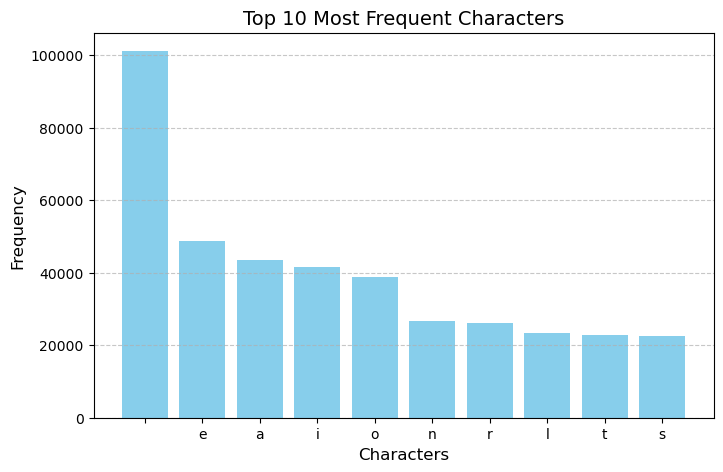

In [2]:
import numpy as np
import requests
from collections import Counter
import matplotlib.pyplot as plt

# URL of the text file containing Dante's "La Divina Commedia"
url = 'https://raw.githubusercontent.com/andreamoleri/AML-Assignments/refs/heads/main/Assignment%204/divina_commedia.txt'

# Download and preprocess the text
text = requests.get(url).text.lower()

# Display text length and a sample of the text
print(f"Text Length:\n{'-' * 35}\n{len(text)} characters")
print(f"\nText Sample:\n{'-' * 35}\n{text[30:828]}")

# Analyze unique characters in the text
chars = sorted(set(text))
print(f"Total Unique Characters:\n{'-' * 35}\n{len(chars)}")

# Create character mappings
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

print(f"\nCharacter-to-Index Mapping:\n{'-' * 35}")
for char, idx in char_indices.items():
    print(f"'{char}': {idx}")

# Define sequence parameters
maxlen, step = 30, 3

# Generate sequences and corresponding next characters
sequences = [(text[i: i + maxlen], text[i + maxlen]) for i in range(0, len(text) - maxlen, step)]
sentences, next_chars = zip(*sequences) if sequences else ([], [])

print(f"\nNumber of Sequences Generated:\n{'-' * 35}\n{len(sentences)}")

if sentences:
    print(f"\nExample of a Sentence:\n{'-' * 35}\nSentence: '{sentences[11]}'\nNext Character: '{next_chars[11]}'")

# Count character frequencies
char_counts = Counter(text)
sorted_counts = char_counts.most_common()

# Display top 10 most frequent characters
print(f"\nTop 10 Most Frequent Characters:\n{'-' * 35}")
for char, count in sorted_counts[:10]:
    print(f"{repr(char):>5}: {count} occurrences")

# Plot top 10 most frequent characters
char_labels, char_freqs = zip(*sorted_counts[:10])
plt.figure(figsize=(8, 5))
plt.bar(char_labels, char_freqs, color='skyblue')
plt.title('Top 10 Most Frequent Characters', fontsize=14)
plt.xlabel('Characters', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Preparing the Data

The preprocessing stage involves preparing sequences from the text data for training, validation, and testing purposes. This phase builds on the previous data inspection results and ensures the sequences are appropriately structured for machine learning models. The initial steps map each unique character into integer indices. As previously discussed, the data is tokenized into sequences of `30` characters, with a step of `3` between each sequence. This choice tries to balance sequence length for context learning while preventing highly overlapping sequences that could lead to redundancies. The text sequences (`sentences`) and their corresponding target characters (`next_chars`) are one-hot encoded into arrays `x` and `y`. Here, each character is transformed into a binary vector representation across `40` unique characters, with `40` being the total number of unique characters identified during the data inspection phase. After encoding, the sequences are split into training, validation, and test subsets. The proportions are set as follows:

- `80%` **for Training**: used to train the machine learning model. As a consequence, the training set is made up of `148,856` sequences with shapes `(30, 40)`
- `10%` **for Validation**: used to tune model hyperparameters and prevent overfitting during training. As a consequence, the validation set is made up of `18,607` sequences with shapes `(30, 40)`
- `10%` **for Testing**: reserved to assess how well the trained model generalizes on unseen data. As a consequence, the test set is made up of `18,607` sequences with shapes `(30, 40)`

In [3]:
# Define the maximum sequence length to be used for training
maxlen = 30

# Obtain the unique characters in the text and sort them to ensure consistent encoding
chars = sorted(set(text))
# Map each unique character to a unique integer index.
char_indices = {char: i for i, char in enumerate(chars)}
# Map each integer index back to its corresponding character.
indices_char = {i: char for char, i in char_indices.items()}
# Display the total number of unique characters.
print(f"Total characters: {len(chars)}")

# Initialize lists to store input sequences and their corresponding target characters
sentences = []
next_chars = []

# Generate sequences of length `maxlen` with their respective next characters as targets
# Loop with a step of 3 to avoid overly similar sequences
for i in range(0, len(text) - maxlen, 3):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])

# Display the total number of sequences generated for training
print(f"Number of sequences generated: {len(sentences)}")

# Initialize the input (x) and output (y) arrays for training with boolean values
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)

# One-hot encode the sequences and their respective next characters
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1  # One-hot encode the input sequence characters
    y[i, char_indices[next_chars[i]]] = 1  # One-hot encode the target characters

# Display the shapes of the input and output arrays to verify their structure
print('\nInput (x) and Output (y) shapes:')
print(x.shape)
print(y.shape)

# Define the proportions of data to be used for training, validation, and testing splits
train_split = 0.8
val_split = 0.1

# Calculate the sizes of the training and validation sets based on the total number of sequences
train_size = int(len(sentences) * train_split)
val_size = int(len(sentences) * val_split)

# Split the data into training, validation, and test sets
x_train, y_train = x[:train_size], y[:train_size]
x_val, y_val = x[train_size:train_size + val_size], y[train_size:train_size + val_size]
x_test, y_test = x[train_size + val_size:], y[train_size + val_size:]

# Display the size of each data split to ensure proper partitioning
print('\nData split:')
print(f'Training set: {x_train.shape}, {y_train.shape}')
print(f'Validation set: {x_val.shape}, {y_val.shape}')
print(f'Test set: {x_test.shape}, {y_test.shape}')

Total characters: 40
Number of sequences generated: 186070

Input (x) and Output (y) shapes:
(186070, 30, 40)
(186070, 40)

Data split:
Training set: (148856, 30, 40), (148856, 40)
Validation set: (18607, 30, 40), (18607, 40)
Test set: (18607, 30, 40), (18607, 40)


In [4]:
import random
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import tensorflow as tf

# Define the hyperparameter search space
param_grid = {
    'chunk_length': [30, 35, 40, 50],
    'lstm_units': [64, 128, 256],
    'dropout_rate': [0.0, 0.2, 0.3],
    'learning_rate': [0.01, 0.005, 0.001],
    'layers': [1, 2],
}

# Randomly select hyperparameters for each model
n_models = 3
random_configs = [
    {
        'chunk_length': random.choice(param_grid['chunk_length']),
        'lstm_units': random.choice(param_grid['lstm_units']),
        'dropout_rate': random.choice(param_grid['dropout_rate']),
        'learning_rate': random.choice(param_grid['learning_rate']),
        'layers': random.choice(param_grid['layers']),
    }
    for _ in range(n_models)
]

models = []

for i, config in enumerate(random_configs):
    print(f"\nBuilding Model {i + 1} with config: {config}...")

    # Adjust data based on chunk length
    chunk_length = config['chunk_length']
    x_train_mod = x_train[:, :chunk_length, :]
    x_val_mod = x_val[:, :chunk_length, :]
    x_test_mod = x_test[:, :chunk_length, :]

    # Build the model
    model = Sequential()

    # Add LSTM layers
    if config['layers'] == 1:
        model.add(LSTM(config['lstm_units'], input_shape=(chunk_length, len(chars))))
    else:
        model.add(LSTM(config['lstm_units'], input_shape=(chunk_length, len(chars)), return_sequences=True))
        model.add(Dropout(config['dropout_rate']))  # Add dropout between layers
        model.add(LSTM(config['lstm_units'] // 2))  # Halve the units for the second layer

    # Add output layer
    model.add(Dense(len(chars), activation='softmax'))

    # Compile the model
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=config['learning_rate'])
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.summary()
    models.append(model)


Building Model 1 with config: {'chunk_length': 50, 'lstm_units': 128, 'dropout_rate': 0.0, 'learning_rate': 0.01, 'layers': 1}...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               86528     
                                                                 
 dense (Dense)               (None, 40)                5160      
                                                                 
Total params: 91688 (358.16 KB)
Trainable params: 91688 (358.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Building Model 2 with config: {'chunk_length': 50, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'layers': 2}...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   

In [5]:
import random
import matplotlib.pyplot as plt
from keras.callbacks import LambdaCallback
import sys

# Helper function to test text generation after each epoch
def testAfterEpoch(model, text, char_indices, indices_char, maxlen, epoch, _):
    print()
    print(f"******* Epoch: {epoch+1} ********")
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence

    print("***** Starting sentence *****")
    print(sentence)
    print("*****************************")

    for _ in range(400):  # Generate 400 characters
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = np.argmax(preds)
        next_char = indices_char[next_index]

        sentence = sentence[1:] + next_char
        generated += next_char

    print("***** Generated text *****")
    print(generated)
    print()

# Function to prepare data for a given chunk length
def prepare_data_for_chunk_length(text, chars, char_indices, maxlen, step=3):
    sentences = []
    next_chars = []
    for i in range(0, len(text) - maxlen, step):
        sentences.append(text[i: i + maxlen])
        next_chars.append(text[i + maxlen])
    x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
    y = np.zeros((len(sentences), len(chars)), dtype=bool)
    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1
    return x, y

# Function to train a model and store the training history for plotting
def train_and_store_history(model, x, y, text, char_indices, indices_char, maxlen, batch_size, epochs, model_name):
    # Split the data into training, validation, and test sets
    split_train = int(len(x) * 0.8)
    split_val = int(len(x) * 0.9)
    x_train, y_train = x[:split_train], y[:split_train]
    x_val, y_val = x[split_train:split_val], y[split_train:split_val]
    x_test, y_test = x[split_val:], y[split_val:]

    print(f"Training {model_name}...")
    print_callback = LambdaCallback(on_epoch_end=lambda epoch, _: testAfterEpoch(model, text, char_indices, indices_char, maxlen, epoch, _))

    # Train the model
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[print_callback],
        verbose=1
    )

    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return history, test_loss, test_accuracy

# Plot training histories
def plot_all_histories(histories, model_names):
    plt.figure(figsize=(12, 18))
    for i, (history, name) in enumerate(zip(histories, model_names)):
        plt.subplot(len(histories), 2, 2 * i + 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{name} - Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(len(histories), 2, 2 * i + 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{name} - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Train and evaluate each model
batch_size = 2048
epochs = 2

histories = []
model_names = []
results = []


# Model 1 - Chunk length = 30
x_1, y_1 = prepare_data_for_chunk_length(text, chars, char_indices, maxlen=30)
print("Evaluating Model 1...")
history_1, test_loss_1, test_accuracy_1 = train_and_store_history(model_1, x_1, y_1, text, char_indices, indices_char, 30, batch_size, epochs, "Model 1")
histories.append(history_1)
model_names.append("Model 1")
results.append(("Model 1", test_loss_1, test_accuracy_1))

# Model 2 - Chunk length = 50
x_2, y_2 = prepare_data_for_chunk_length(text, chars, char_indices, maxlen=35)
print("\nEvaluating Model 2...")
history_2, test_loss_2, test_accuracy_2 = train_and_store_history(model_2, x_2, y_2, text, char_indices, indices_char, 35, batch_size, epochs, "Model 2")
histories.append(history_2)
model_names.append("Model 2")
results.append(("Model 2", test_loss_2, test_accuracy_2))

# Model 3 - Chunk length = 70
x_3, y_3 = prepare_data_for_chunk_length(text, chars, char_indices, maxlen=40)
print("\nEvaluating Model 3...")
history_3, test_loss_3, test_accuracy_3 = train_and_store_history(model_3, x_3, y_3, text, char_indices, indices_char, 40, batch_size, epochs, "Model 3")
histories.append(history_3)
model_names.append("Model 3")
results.append(("Model 3", test_loss_3, test_accuracy_3))

# Plot all histories together at the end
plot_all_histories(histories, model_names)

# Test Results Section
print("\nTest Results:\n")
results.sort(key=lambda x: x[2], reverse=False)
for model_name, test_loss, test_accuracy in results:
    print(f"{model_name} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Evaluating Model 1...


NameError: name 'model_1' is not defined

In [ ]:
import sys
def testAfterEpoch(epoch, _):
  print()
  print()
  print('******* Epoch: %d ********' % (epoch+1))
  start_index = random.randint(0, len(text)-maxlen-1)

  generated = ''
  sentence = text[start_index :  start_index + maxlen]
  generated = generated + sentence

  print('***** starting sentence *****')
  print(sentence)
  print('*****************************')
  sys.stdout.write(generated)

  for i in range(400):
    x_pred = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
      x_pred[0, t, char_indices[char]] = 1

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = np.argmax(preds)
    next_char = indices_char[next_index]

    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
  print()



In [ ]:
print_callback = LambdaCallback(on_epoch_end=testAfterEpoch)

In [ ]:
model.fit(x, y,
          batch_size = 2048,
          epochs = 20,
          callbacks = [print_callback])

Epoch 1/20
91/91 [==============================] - ETA: 0s - loss: 2.6218

******* Epoch: 1 ********
***** starting sentence *****
olui che tutto 'l mondo alluma
*****************************
olui che tutto 'l mondo alluma la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la 
91/91 [==============================] - 75s 806ms/step - loss: 2.6218
Epoch 2/20
91/91 [==============================] - ETA: 0s - loss: 2.0454

******* Epoch: 2 ********
***** starting sentence *****
e o lievemente o forte>>.

que
*****************************
e o lievemente o forte>>.

quen la per la ser con per la per la per la per la per la per la per la per la per la